In [1]:
import keras.backend as K
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn.neighbors as skn
from random import randrange

2023-03-27 14:11:06.591452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# CRONOMETRARE

# CONTROLLARE

# OTTIMIZZARE (SPECIALMENTE GLI ULTIMI DUE ASSIGNMENT CON PRECOMPUTING)

# NELLE FUNZIONI DEFINITE CAPIRE BENE QUALI SONO I PARAMETRI DI INPUT CHE SI ASPETTANO DI AVERE
# (SOPRATTUTTO CAPIRE SE BISOGNA PASSARE ANCHE I DATASET)

# COMMENTARE

### importing the dataset

In [2]:
# splitting data in train and set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# input images dimensions
img_rows, img_cols = 28, 28

# preparing images
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols)
    input_shape = (img_rows, img_cols)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

np.savez_compressed('mnist.npz', x_train, y_train, x_test, y_test)

In [4]:
arc = np.load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


we try to print one of the images (the number 15)

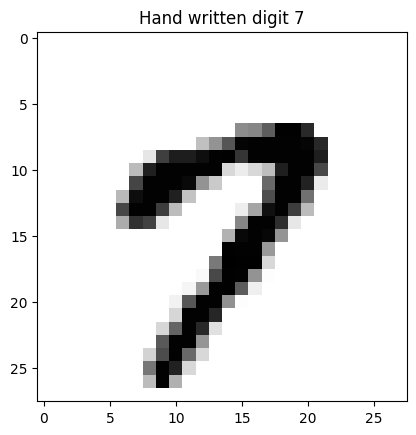

In [5]:
N=15

plt.imshow(x_train[N], cmap='gray_r')
_ = plt.title('Hand written digit '+str(y_train[N]))

### Assignment one
Defining different distances

In [5]:
def dist_infty(a, b):
    return np.max(np.fabs(a - b))

def dist_1(a, b):
    return np.sum(np.fabs(a - b))

# here we removed the absolute value to enhance performance
def dist_2(a, b):
    return math.sqrt(np.sum((a - b)**2))

timing the distance functions

In [7]:
test1 = x_train[randrange(x_test.shape[0])]
test2 = x_train[randrange(x_test.shape[0])]

In [160]:
%%timeit
dist_infty(test1, test2)

13.9 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [164]:
%%timeit
dist_1(test1, test2)

13 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [165]:
%%timeit
dist_2(test1, test2)

12.5 µs ± 610 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Assignment two
Computing distance among first N elements of the train dataset

In [6]:
def dist_mat(N, dist):

    # initializing matrix of distances
    D = np.empty((N, N))

    for i in range(N):
        # computing only the non trivial distances
        D[i, i] = 0
        D[i, i+1:N] = np.array([dist(x_train[i], x_train[j]) for j in range(i+1, N)])
        D[i+1:N, i] = D[i, i+1:N]

    return D

In [167]:
# displaying some results (saved in CSV file)
N_first = 100
np.savetxt("dist_max.csv", dist_mat(N_first, dist_1), delimiter=",")

testing and timing dist_mat()

In [7]:
test = False
for dist in [dist_infty, dist_1, dist_2]:

    D_test = dist_mat(300, dist)

    # comparison
    for i in range(300):
        for j in range(300):
            if D_test[i, j] - dist(x_train[i], x_train[j]) > 1e-10:
                test = True

print(test)

False


In [51]:
%%timeit
dist_mat(300, dist_infty)

675 ms ± 70.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit
dist_mat(300, dist_1)

591 ms ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
%%timeit
dist_mat(300, dist_2)

704 ms ± 8.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Assignment three
Computing and plotting the distance matrices (for the first 100 images); the darker the 'pixel' the higher the distance

In [8]:
Dinfty = dist_mat(100, dist_infty)
D1 = dist_mat(100, dist_1)
D2 = dist_mat(100, dist_2)

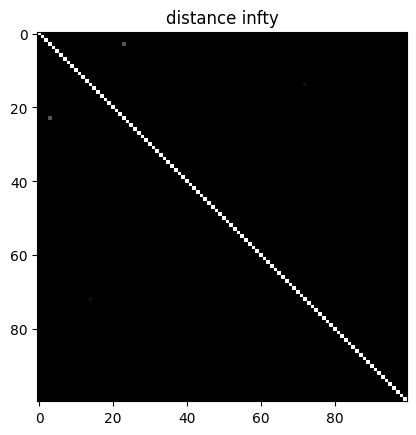

In [170]:
plt.imshow(Dinfty, cmap='gray_r')
_ = plt.title('distance infty')

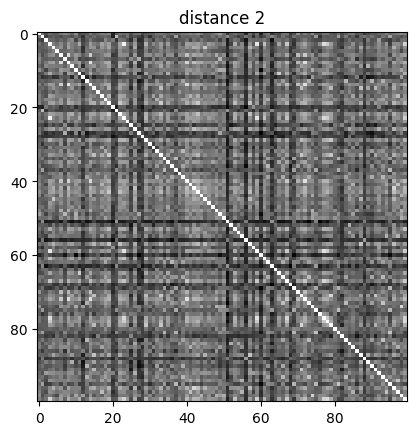

In [171]:
plt.imshow(D1, cmap='gray_r')
_ = plt.title('distance 2')

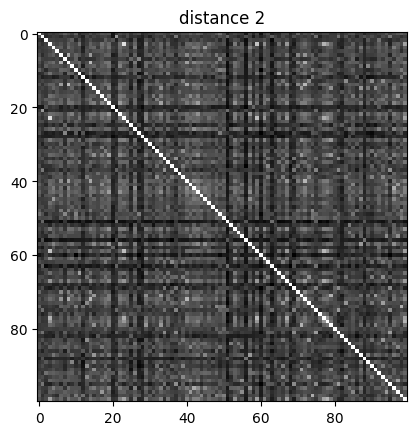

In [9]:
plt.imshow(D2, cmap='gray_r')
_ = plt.title('distance 2')

### Assignment four
Applying and testing the algorithm

In [10]:
def comp_error(D):

    error_counter = 0
    dim = D.shape[0]

    for i in range(dim):
        
        # finding the index j of the nearest image to the i-th one
        j = np.argmin(np.concatenate((D[i, :i], D[i, i+1:])))
        if j > i:
            j += 1
        
        if y_train[i] != y_train[j]:
            error_counter += 1
    
    return error_counter/dim

In [11]:
print(comp_error(Dinfty))
print(comp_error(D1))
print(comp_error(D2))

0.58
0.16
0.16


timing the function

In [176]:
%%timeit
comp_error(Dinfty)

737 µs ± 44.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [177]:
%%timeit
comp_error(D1)

779 µs ± 116 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [178]:
%%timeit
comp_error(D2)

825 µs ± 62.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Assignment five
Computing the error for different N's using different distances

In [12]:
N_test = (100,200,400,800,1600)

error = np.empty((len(N_test), 3))   # each row a different N and each column a different distance

for i in range(len(N_test)):
    error[i, 0] = comp_error(dist_mat(N_test[i], dist_infty))
for i in range(len(N_test)):
    error[i, 1] = comp_error(dist_mat(N_test[i], dist_1))
for i in range(len(N_test)):
    error[i, 2] = comp_error(dist_mat(N_test[i], dist_2))

In [13]:
display(error)

array([[0.58    , 0.16    , 0.16    ],
       [0.52    , 0.145   , 0.135   ],
       [0.4425  , 0.15    , 0.135   ],
       [0.4     , 0.145   , 0.12875 ],
       [0.369375, 0.1025  , 0.09375 ]])

In [23]:
# NON VA BENE PER NULLA

DDD = dist_mat(10000, dist_1)
eee = comp_error(DDD)
print(eee)

0.4658


### Assignment six
Exploiting the neighboring information of the pixels. We will use thenumpy functions gradient() and trapz() to compute gradients and integrals of the images

In [71]:
dim = x_train[0].shape[0]
dim2 = dim**2

def dist_H1(a, b):

    # needed in the BallTree algorithm (since we must pass to it 1D arrays)
    if a.shape[0] == dim2:
        a = a.reshape((dim, dim))
    if b.shape[0] == dim2:
        b = b.reshape((dim, dim))

    # integrals
    a_int = np.trapz(np.trapz(a))
    b_int = np.trapz(np.trapz(b))
    # normalized functions
    a_norm = a / a_int
    b_norm = b / b_int
    # squared gradient
    grad = np.gradient(a-b)
    grad_2 = np.fabs(grad[0]**2 + grad[1]**2)
    # final integral
    integral = np.trapz(np.trapz(grad_2 + (a-b)**2))

    return math.sqrt(integral)

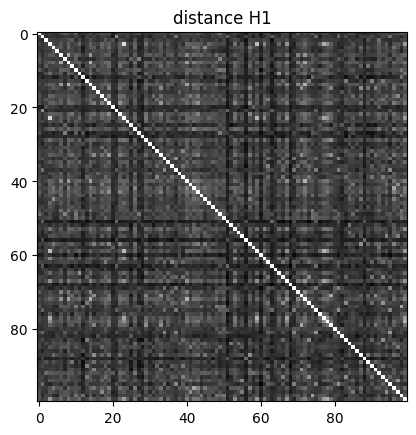

In [45]:
# displaying some results

DH1 = dist_mat(100, dist_H1)
plt.imshow(DH1, cmap='gray_r')
_ = plt.title('distance H1')

testing the function

In [46]:
N_test = (100, 200, 400, 800, 1600)

error_H1 = np.empty(len(N_test))

for i in range(len(N_test)):
    error_H1[i] = comp_error(dist_mat(N_test[i], dist_H1))

In [47]:
display(error_H1)

array([0.64    , 0.575   , 0.58    , 0.54875 , 0.496875])

timing the distance function

In [64]:
%%timeit
dist_H1(test1, test2)

222 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [66]:
%%timeit
dist_mat(300, dist_H1)

8.7 s ± 238 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Assignment seven
Using BallTree algorithm

In [28]:
# we need to reshape the images data to be able to use the BallTree
height = x_train.shape[0]
width = 28**2
x_train_reshaped = x_train.reshape((height, width))

In [29]:
# again we have to reshape the images data
x_test_reshaped = x_test.reshape((x_test.shape[0], width))

In [89]:
def comp_error_bt(tree):

    error_counter = 0
    dim = x_test_reshaped.shape[0]

    # querying the tree
    response_index = tree.query(x_test_reshaped, return_distance=False)
    response = y_train[response_index]
    
    # counting wrong predictions
    for i in range(dim):
        if (response[i] != y_test[i]):
            error_counter+=1
    
    # we tried to use the following line instead of the loop but the performance was
    # not improved at all
    #error_counter = np.sum(np.array([response != y_test]))
    
    return error_counter/dim

timing comp_error_bt using the first 20 images

In [74]:
tree_test = skn.BallTree(x_train_reshaped[:20, :], metric=dist_infty)

In [87]:
%%timeit
comp_error_bt(tree_test)

2.89 s ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
# MOLTO LENTO COSÌ (QUASI 10 VOLTE PIÙ LENTO DI DIST_INFTY)

bag = []
for i in range(400):
    bag.append(x_train_reshaped[i, :])
bag = tuple(bag)

def dist_infty_mod(a, b, sample_size):
    i=-1
    j=-1
    k=0
    while k < sample_size:
        if (bag[k]==a).all():
            i=k
        if (bag[k]==b).all():
            j=k
        k+=1
    if i==-1 or j==-1:
        return np.max(np.abs(a-b))
    else:
        return Dinfty[i, j]

In [90]:
N_test_bt = tuple(range(1000, 3001, 1000))   # METTERE I VALORI RICHIESTI (QUESTI SONO SOLO PER TEST)
error_bt = np.empty((len(N_test_bt), 4))   # each row a different N and each column a different distance

for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_infty)
    #tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_infty_mod, sample_size=N_test_bt[i])
    error_bt[i, 0] = comp_error_bt(tree)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_1)
    error_bt[i, 1] = comp_error_bt(tree)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_2)
    error_bt[i, 2] = comp_error_bt(tree)
#for i in range(len(N_test_bt)):
#    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_H1)
#    error_bt[i, 3] = comp_error_bt(tree)

In [77]:
display(error_bt)

array([[ 0.3687    ,  0.0939    ,  0.0809    , 13.69389911]])

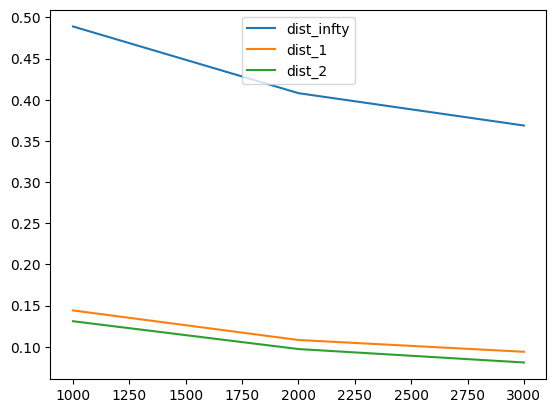

In [91]:
# plot of the error for the four distances as function of N
plt.plot(N_test_bt, error_bt[:, 0], label='dist_infty')
plt.plot(N_test_bt, error_bt[:, 1], label='dist_1')
plt.plot(N_test_bt, error_bt[:, 2], label='dist_2')
#plt.plot(N_test_bt, error_bt[:, 3], label='dist_H1')
leg = plt.legend(loc='upper center')
plt.show()

## to fix stuff

In [70]:
tree = skn.BallTree(x_train_reshaped[:100, :], metric=dist_H1)

IndexError: list assignment index out of range